In [280]:
import pandas as pd
import numpy as np
#read the dataframe
d1 = pd.read_csv(r"sample_dataset.csv")
d1.head()

,MAXSCORE,PREVCOLL,GIFCLS,PRIORVIS,DBPBAL,AFADCODE,DBATYP,GIPTSR,MIDCOLL,CSPCCAVL,...,CSPMTG#,AFACCD,HOMEVAL,HHINC,PCINC,FAMILY,HOMEOWNER,MARRIED,COLLEGE,OUTCOME
0,800,3666.83,80,39,19.92,;,2,;,0.0,0,...,0,;,95400,52852,29890,63.3,94.1,50.1,45.9,GOOD
1,820,1195.94,84,81,15.00,;,2,1,0.0,0,...,0,;,198175,64380,27124,80.8,89.8,66.8,26.0,GOOD
2,761,3390.26,84,28,60.00,S,2,1,0.0,0,...,0,;,309900,62195,50301,73.0,80.8,68.4,43.1,GOOD
3,875,1356.77,80,9,39.32,;,2,3,0.0,0,...,0,;,31220,28209,15106,67.5,83.8,67.1,19.0,GOOD
4,687,898.92,14,5,3434.90,S,1;7;8,3,0.0,6500,...,0,;,113107,70391,27265,81.6,75.9,67.9,43.6,GOOD


In [281]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = d1.select_dtypes(include=numerics)

#find columns that are categorical
obj=[]
for cols in d1.columns:
    if cols not in newdf.columns:
        obj.append(cols)      


In [282]:
#converting some categorical columns to numerical columns
def mak(col):
    if len(col)>0 and col!=' ':
        return float(col)
    elif col==' ':
        return 0
    
    
d1['GIFCLS']=d1['GIFCLS'].apply(mak)

def mak1(col):
    if len(col)>0 and col!=';':
        return float(col)
    elif col==';':
        return 0
    
    
d1['TSC1STFACT']=d1['TSC1STFACT'].apply(mak1)
d1['GIPTSR']=d1['GIPTSR'].apply(mak1)


In [283]:
#check which columns are categorical now after the conversion of some
obj1=[]
for cols in d1.columns:
    if cols not in newdf.columns:
        obj1.append(cols)
obj1.remove('OUTCOME')

#one hot encoding for categorical columns
d2 = pd.get_dummies(d1, columns=obj1)


In [284]:
#split into test and train
from sklearn.model_selection import train_test_split
X =d2.drop('OUTCOME',axis=1) # Features
y = d2['OUTCOME']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [285]:
#define the model
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3,random_state=0)
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7746666666666666


In [286]:
def gettreetable(clf,X): 
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn import tree

    #get details of the tree
    p = tree.plot_tree(clf,feature_names=X.columns,fontsize=6,filled=True)
    def ext(it):
       h = str(it).split(',')[2].split('\\')
       h1 = h[0].split('<')[0]
       spl = h[0].split('\nentropy')[0].replace(h1,'')
       #h2 = h[2].split('=')[1]
       h2 = str(it).split('nsamples =')[1].split("\\")[0].strip()
       h4 = str(it).split(',')[3]
       import re
       h4 = re.findall(r'\d+',h4)
       h2 = re.findall(r'\d+',h2)
       h3 = float(h2[0])-float(h4[0])
       h1 =h1.strip("'")
       return h1,h2[0],h3,h4[0],spl

    m=[]
    #get details of all nodes
    for it in p:
        m.append([ext(it)[0],ext(it)[1],ext(it)[2],ext(it)[3],ext(it)[4]])

    #make a dataframe out of the extracted features
    m1 = pd.DataFrame(m)
    m1.columns = ['Column','Number of Samples', 'Split Value - Bad', 'Split Value - Good' , 'Split']

    def mak(col):
        if 'entropy' in col:
            return 'Empty'
        else:
            return col
    m1['Column'] = m1['Column'].apply(mak)


    #get parent node for each node
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right


    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    
    parent=[]
    for i in range(n_nodes):
        if is_leaves[i]:
           pass
        else:
            parent.append([i,children_left[i],children_right[i]])
    parent = pd.DataFrame(parent)
    parent.columns =['Parent','N1','N2']
    parent1 = parent[['Parent','N1']]
    parent2 = parent[['Parent','N2']]
    conn = pd.concat([parent1,parent2])
    conn['N1'].fillna(conn['N2'],inplace=True)
    conn = conn[['Parent','N1']]
    conn.columns =['Parent','Node']
    conn.sort_values(by='Node',ascending=False)

    #merge the parent node column to the first datadrame
    l =[float(i) for i in range(0,n_nodes)]
    m1['Node']=l
    mer = pd.merge(m1,conn,on='Node',how='left')


    mer['Split Value - Good'] = mer['Split Value - Good'].astype(float)
    mer['Number of Samples'] = mer['Number of Samples'].astype(float)

    mer['Percent_GOOD']= mer['Split Value - Good']*100/mer['Number of Samples']


    ns = mer['Number of Samples'].values.tolist()[0]
    mer['Percent']= mer['Number of Samples']*100/ns

    def cat(col):
        if col>=50:
            return 'GOOD'
        else:
            return 'BAD'

    mer['Predicted Category']=mer['Percent_GOOD'].apply(cat)
    def change(col):
        if "'" in col:
            return col.replace("'",'')
        elif col=='Empty':
            return 'Leaf Node'
        else:
            return col

    mer['Column']=mer['Column'].apply(change)



    mer.rename(columns={'Column':'Variable','Number of Samples':'Nb','Parent':'Parent Node'},inplace=True)
    mer = mer[['Node','Nb','Percent_GOOD','Percent','Predicted Category','Parent Node','Variable','Split','Split Value - Bad','Split Value - Good']]
    return mer


,Node,Nb,Percent_GOOD,Percent,Predicted Category,Parent Node,Variable,Split,Split Value - Bad,Split Value - Good
0,0.0,7000.0,43.585714,100.000000,BAD,NaN,MAXSCORE,<= 683.5,3949.0,3051.0
1,1.0,4179.0,24.024886,59.700000,BAD,0.0,PREVCOLL,<= 5.01,3175.0,1004.0
2,2.0,2513.0,11.341027,35.900000,BAD,1.0,MAXSCORE,<= 202.5,2228.0,285.0
3,3.0,530.0,28.301887,7.571429,BAD,2.0,Leaf Node,,380.0,150.0
4,4.0,1983.0,6.807867,28.328571,BAD,2.0,Leaf Node,,1848.0,135.0
5,5.0,1666.0,43.157263,23.800000,BAD,1.0,MAXSCORE,<= 204.0,947.0,719.0
6,6.0,530.0,73.773585,7.571429,GOOD,5.0,Leaf Node,,139.0,391.0
7,7.0,1136.0,28.873239,16.228571,BAD,5.0,Leaf Node,,808.0,328.0
8,8.0,2821.0,72.562921,40.300000,GOOD,0.0,PREVCOLL,<= 35.615,774.0,2047.0
9,9.0,855.0,57.894737,12.214286,GOOD,8.0,DBPBAL,<= 4128.59,360.0,495.0


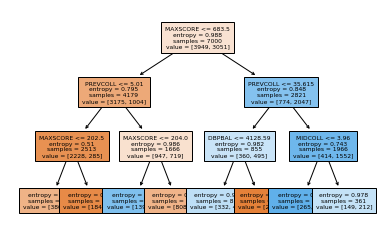

In [287]:
k = gettreetable(clf,X)
k

In [263]:
k.to_csv(r"treetable.csv",index=False)

In [290]:
k.to_csv(r'treetable1.txt', index=None, sep='|')
